In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from umap import UMAP
import string
from sklearn.model_selection import train_test_split


/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data and tokenization

In [2]:


def clean_data(dato_csv):
    """
    This function cleans the input DataFrame and ouput DataFrame.
    Remove Missing Values: Drops rows with any missing values.
    Convert to String: Ensures all data is treated as strings for consistency.
    Remove Duplicates: Drops duplicate rows.
    Filter Short Texts: Removes rows where the length of the text is less than 20 characters.
    Convert to Lowercase: Converts all text to lowercase.
    Remove Special Characters: Removes any characters that are not words or whitespace N = 20.
    """
    dato_csv = dato_csv.dropna()  # Remove rows with missing values
    dato_csv = dato_csv.astype(str)  # Convert all data to string
    dato_csv = dato_csv.drop_duplicates()  # Remove duplicate rows
    dato_csv = dato_csv[dato_csv['text'].str.len() >= 20]  # Remove rows where 'text' length is less than 20

    # esto ya lo hace por defecto tfidvecotirzer:
    #for column in dato_csv.columns:
        #dato_csv[column] = dato_csv[column].str.lower()  # Convert to lowercase-->done dirctly by TFIDvectorizer
       # dato_csv[column] = dato_csv[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove special characters

    return dato_csv

In [3]:
# File paths for input CSV files

file_path_test = 'data/test.csv'
file_path_train = 'data/train.csv'

# Read CSV files
df_test = pd.read_csv(file_path_test)
df_train = pd.read_csv(file_path_train)

# Clean data
df_test = clean_data(df_test)
df_train = clean_data(df_train)


print(df_train.head())

  id                                              title              author  \
0  0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1  1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2  2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3  3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4  4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...     1  
1  Ever get the feeling your life circles the rou...     0  
2  Why the Truth Might Get You Fired October 29, ...     1  
3  Videos 15 Civilians Killed In Single US Airstr...     1  
4  Print \nAn Iranian woman has been sentenced to...     1  


## We keep only the text in English

In [4]:
# Function to detect and filter only English text from a corpus and edit the original DataFrame
def filter_english_text_edit_df(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    # Initialize an empty list to store indices of rows to keep
    keep_indices = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        text = row[text_column]
        try:
            # Detect the language of the text
            if detect(text) == 'en':
                # If the language is English, add the index to the list of keep_indices
                keep_indices.append(index)
        except:
            # If language detection fails (raises an exception), skip the text
            pass
    
    # Filter the original DataFrame to keep only the rows where text is in English
    filtered_df = df.loc[keep_indices].reset_index(drop=True)
    
    return filtered_df

## VECTORIZATION: Language detection function and  TF-IDF vectors. 
We save the unigrams TF-IDF vectors (single words) and bigrams TF-IDF vectors (pairs of consecutive words). We create visualizations to show the distribution of the vectors and how the unigrams and bigrams are repeated in the case of fake or real news.

In [5]:
# Function to vectorize text using TF-IDF
def get_tfidf_vectors(corpus: np.ndarray, stop_words: str, max_features: int, n: int) -> np.ndarray:
    # Create a TfidfVectorizer object with the given parameters:
    # - stop_words: language for stop words (e.g., 'english') or None to include all words
    # - max_features: maximum number of features (terms) to consider when vectorizing
    # - ngram_range: range of n-grams to consider; (n, n) means only n-grams of size 'n'
    
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, ngram_range=(n, n))
    
    # Fit the vectorizer to the corpus and transform the text data into TF-IDF vectors
    vectorized = vectorizer.fit_transform(corpus)
    
    # Return the resulting TF-IDF vectors
    return vectorized

In [6]:

# Filter to only include English text
df_train_en = filter_english_text_edit_df(df_train, 'text')


labels1 = df_train_en.copy()['label'].values
labels = [int(label) for label in labels1]
filtered_corpus = df_train_en.copy()['text'].values

max_features = 30  #esto se puede cambiar

unigram_vectors_without_stopwords = get_tfidf_vectors(filtered_corpus, 'english', max_features, 1)
bigram_vectors_without_stopwords = get_tfidf_vectors(filtered_corpus, 'english', max_features, 2)


In [7]:

# Method: Principal Component Analysis (PCA)
# Uniform Manifold Approximation and Projection (UMAP)
# t-Distributed Stochastic Neighbor Embedding (t-SNE)

def plot_tfidf_vectors(X: np.ndarray, labels: np.ndarray, title: str) -> None:
    pca = PCA(n_components=2, random_state=27).fit_transform(X.toarray())
    tsne = TSNE(n_components=2, init="random", random_state=27, perplexity=30, n_iter=1000, n_jobs=-1).fit_transform(X)
    umap = UMAP(n_components=2, random_state=27, n_neighbors=5, min_dist=0.8, n_jobs=-1).fit_transform(X.toarray())

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
#
    axes[0].scatter(pca[:,0], pca[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[0].set_title('PCA', fontsize=10)
    axes[1].scatter(umap[:,0], umap[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[1].set_title('UMAP', fontsize=10)
    axes[2].scatter(tsne[:,0], tsne[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[2].set_title('t-SNE', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spe

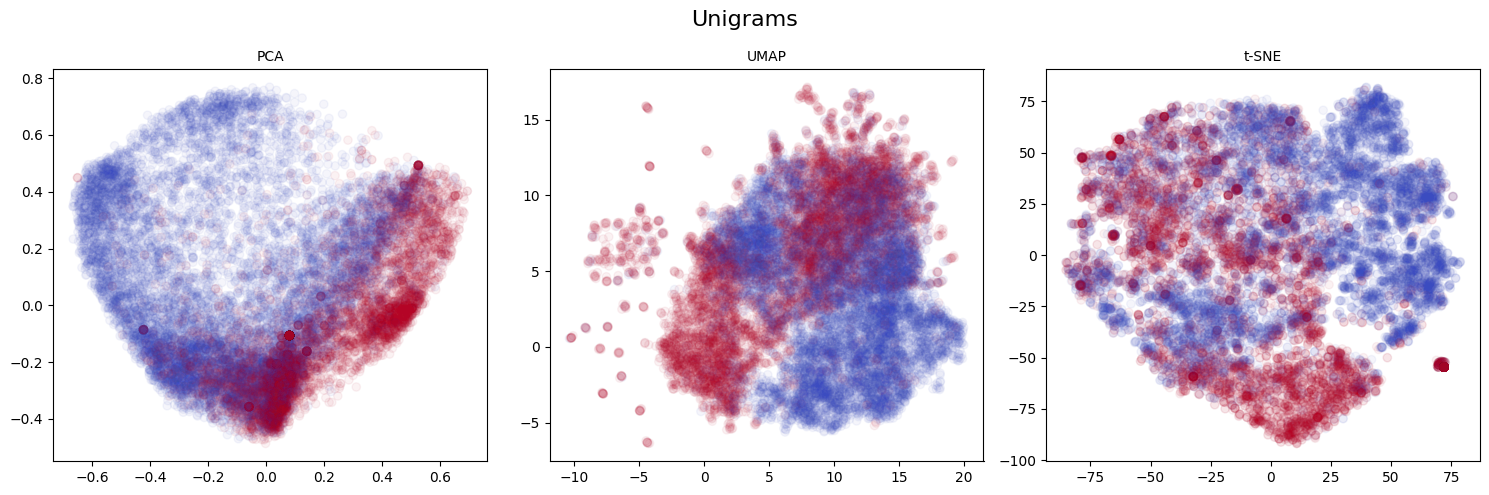

In [8]:
plot_tfidf_vectors(unigram_vectors_without_stopwords, labels, 'Unigrams')


/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spe

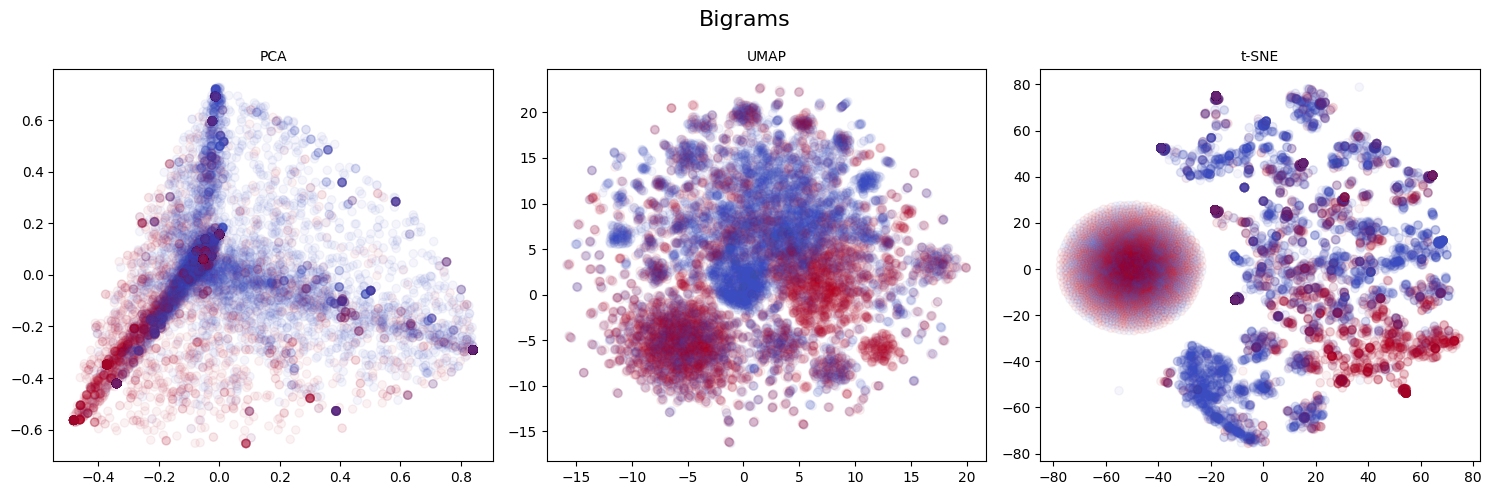

In [9]:
plot_tfidf_vectors(bigram_vectors_without_stopwords, labels, 'Bigrams')

In [10]:
#separo en train y validation: Uso X=los vectores que calcule a partir de la amtrix Tfid (en este caso unigramas). 
# y como 'y' a los labels. 

X_train, X_test, y_train, y_test = train_test_split(unigram_vectors_without_stopwords, labels, random_state=1)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (13421, 30)
X_test shape: (4474, 30)


In [11]:
# Convertir los arrays a DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Guardar los DataFrames en archivos CSV
X_train_df.to_csv('X_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

In [ ]:
# Para cargar los archivos más tarde
#X_train = pd.read_csv('X_train.csv').values
#X_test = pd.read_csv('X_test.csv').values
#y_train = pd.read_csv('y_train.csv').values
#y_test = pd.read_csv('y_test.csv').values